In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
model = "meta-llama3-70b-instruct"
n_tokens = 100
device = "A100 PCIe 80GB"

stats_df = pd.read_csv('data/%s_users_stats.csv' % model)
stats_history_df = pd.read_csv('data/%s_users_stats_history.csv' % model)
gpu_util_df = pd.read_csv('data/%s_gpu_util.csv' % model)

In [3]:
stats_df

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,POST,/v1/completions,9407,40,120000.0,123566.831436,3.388026,254642.893348,761.666525,18.78855,...,162000,186000,201000,226000,244000,250000,251000,254000,255000,255000
1,NaN,Aggregated,9407,40,120000.0,123566.831436,3.388026,254642.893348,761.666525,18.78855,...,162000,186000,201000,226000,244000,250000,251000,254000,255000,255000


In [4]:
stats_history_df['Timestamp'] = stats_history_df['Timestamp'].astype(int)
gpu_util_df['Timestamp'] = gpu_util_df['Timestamp'].astype(int)

In [5]:
merged_data = pd.merge_asof(stats_history_df.sort_values('Timestamp'),
                            gpu_util_df.sort_values('Timestamp'),
                            on='Timestamp',
                            direction='nearest')
merged_data['Timestamp'] = merged_data['Timestamp'] - merged_data['Timestamp'][0]

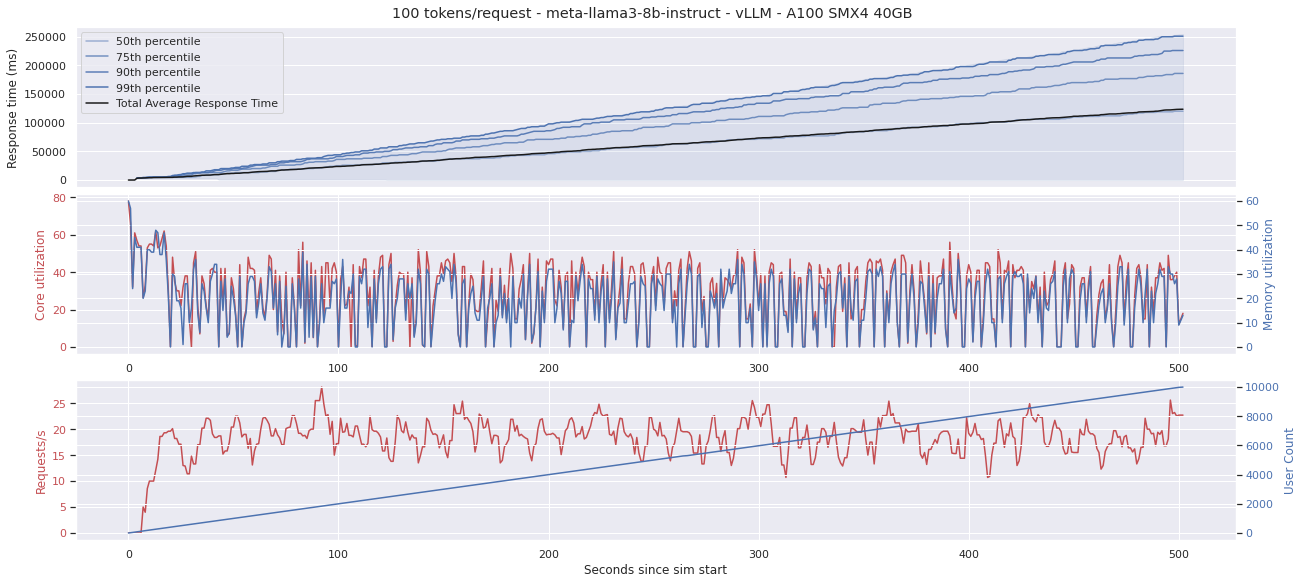

In [6]:
fig, axs = plt.subplot_mosaic([
    ['response_time'],
    ['utilization'],
    ['requests'],
], layout='constrained', figsize=(18,8))

fig.suptitle('%s tokens/request - %s - vLLM - %s' % (n_tokens, model, device))

axs['response_time'].set_ylabel('Response time (ms)')
axs['response_time'].plot(merged_data['Timestamp'], merged_data['50%'], color='b', alpha=.5, label='50th percentile')
axs['response_time'].plot(merged_data['Timestamp'], merged_data['75%'], color='b', alpha=.75, label='75th percentile')
axs['response_time'].plot(merged_data['Timestamp'], merged_data['90%'], color='b', alpha=.9, label='90th percentile')
axs['response_time'].plot(merged_data['Timestamp'], merged_data['99%'], color='b', alpha=.99, label='99th percentile')
axs['response_time'].plot(merged_data['Timestamp'], merged_data['Total Average Response Time'], color='k', alpha=1, label='Total Average Response Time')
axs['response_time'].fill_between(merged_data['Timestamp'], merged_data['Total Min Response Time'], merged_data['Total Max Response Time'], color='b', alpha=.1)

axs['response_time'].legend()
axs['response_time'].set_xticks([])

axs['utilization'].plot(merged_data['Timestamp'], merged_data['GPU Utilization (%)'], c='r', label='Core utilization')
axs['utilization'].set_ylabel('Core utilization', color='r')
axs['utilization'].tick_params(axis='y', labelcolor='r')

ax_memory = axs['utilization'].twinx()
ax_memory.plot(merged_data['Timestamp'], merged_data['GPU Memory Utilization (%)'], c='b', label='Memory utilization')
ax_memory.set_ylabel('Memory utilization', color='b')
ax_memory.tick_params(axis='y', labelcolor='b')

axs['requests'].plot(merged_data['Timestamp'], merged_data['Requests/s'], color='r', label='Requests/s')
axs['requests'].set_xlabel('Seconds since sim start')
axs['requests'].set_ylabel('Requests/s', color='r')
axs['requests'].tick_params(axis='y', labelcolor='r')

total_users = axs['requests'].twinx()
total_users.plot(merged_data['Timestamp'], merged_data['User Count'], color='b', label='User Count')
total_users.set_ylabel('User Count', color='b')
total_users.tick_params(axis='y', labelcolor='b')

plt.savefig('%s_tokens_%s_%s.png' % (n_tokens, model, device))